# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://compsci682-fa18.github.io/assignments2018/assignment1/) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [13]:
import random
import numpy as np
from cs682.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs682/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Clear previously loaded data.
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs682/classifiers/softmax.py**. 


In [15]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs682/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs682.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.397489
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** 

We expect the loss to be close to -log(0.1) because we have 10 classes. There is a 1/10th chance of selecting each class. 


In [16]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs682.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 6.287602 analytic: 6.287602, relative error: 9.485562e-09
numerical: -1.919614 analytic: -1.919614, relative error: 9.045675e-10
numerical: 4.237143 analytic: 4.237143, relative error: 9.492963e-09
numerical: 0.476701 analytic: 0.476701, relative error: 2.330504e-08
numerical: -2.202478 analytic: -2.202478, relative error: 1.708274e-08
numerical: -0.074193 analytic: -0.074193, relative error: 5.592320e-07
numerical: -1.616027 analytic: -1.616027, relative error: 1.457989e-08
numerical: -0.666957 analytic: -0.666957, relative error: 1.815791e-08
numerical: -2.237066 analytic: -2.237066, relative error: 7.087218e-09
numerical: 1.871338 analytic: 1.871338, relative error: 2.116737e-08
numerical: 2.905001 analytic: 2.909179, relative error: 7.186291e-04
numerical: -2.793639 analytic: -2.793950, relative error: 5.562537e-05
numerical: -0.276179 analytic: -0.282727, relative error: 1.171572e-02
numerical: -2.876874 analytic: -2.869653, relative error: 1.256509e-03
numerical: -0.13

In [17]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs682.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.397489e+00 computed in 0.666219s
vectorized loss: 2.397489e+00 computed in 0.011968s
Loss difference: 0.000000
Gradient difference: 0.000000


That took 22.561671s


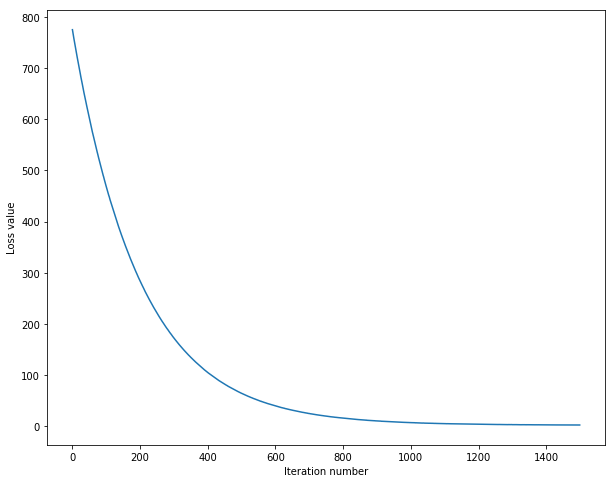

In [18]:
#Bryon Kucharski - just for a sanity check like svm
from cs682.classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=False)
toc = time.time()
print('That took %fs' % (toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [19]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs682.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
#learning_rates = [1e-7, 5e-7]
#regularization_strengths = [2.5e4, 5e4]
learning_rates = [1e-7,2e-7,3e-7,4e-7,5e-7]
regularization_strengths = [1.5e4,1.75e4,2.0e4]


for lr in learning_rates:
    for reg_str in regularization_strengths:
        #print("Running" + str((lr,reg_str)))
        softmax = Softmax()
        loss_hist = softmax.train( X_train,  y_train, learning_rate=lr, reg=reg_str, num_iters=1500, verbose=False)
        y_valid_pred = softmax.predict( X_val)
        y_train_pred = softmax.predict(X_train)
        valid_accuracy =  (np.mean(y_val == y_valid_pred) )
        train_accuracy =  (np.mean(y_train == y_train_pred) )
        if valid_accuracy > best_val:
            best_val = valid_accuracy
            best_softmax = softmax
             
        results[(lr,reg_str)] = (train_accuracy, valid_accuracy)

    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 1.500000e+04 train accuracy: 0.351286 val accuracy: 0.360000
lr 1.000000e-07 reg 1.750000e+04 train accuracy: 0.349980 val accuracy: 0.358000
lr 1.000000e-07 reg 2.000000e+04 train accuracy: 0.353755 val accuracy: 0.363000
lr 2.000000e-07 reg 1.500000e+04 train accuracy: 0.363041 val accuracy: 0.372000
lr 2.000000e-07 reg 1.750000e+04 train accuracy: 0.355327 val accuracy: 0.370000
lr 2.000000e-07 reg 2.000000e+04 train accuracy: 0.355061 val accuracy: 0.367000
lr 3.000000e-07 reg 1.500000e+04 train accuracy: 0.361980 val accuracy: 0.378000
lr 3.000000e-07 reg 1.750000e+04 train accuracy: 0.355204 val accuracy: 0.375000
lr 3.000000e-07 reg 2.000000e+04 train accuracy: 0.357551 val accuracy: 0.370000
lr 4.000000e-07 reg 1.500000e+04 train accuracy: 0.360898 val accuracy: 0.376000
lr 4.000000e-07 reg 1.750000e+04 train accuracy: 0.362122 val accuracy: 0.374000
lr 4.000000e-07 reg 2.000000e+04 train accuracy: 0.357449 val accuracy: 0.369000
lr 5.000000e-07 reg 1.500000

In [20]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.365000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:
True
*Your explanation*:

The SVM loss uses the max() function. If the new datapoint sets this equation to 0, then it does not change this. Softmax takes every datapoint into consideration when computing the loss

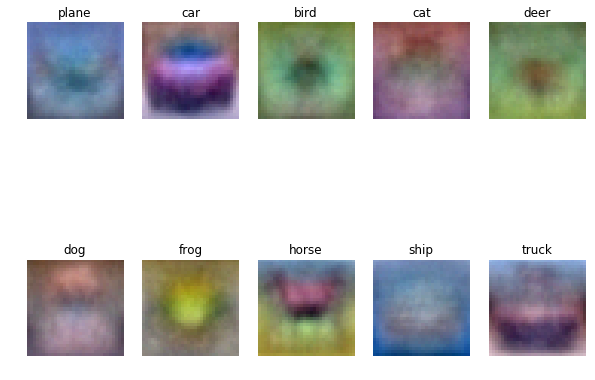

In [21]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])